In [1]:
import numpy as np
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt

from floquet import *

In [2]:
def mas_frq(hamiltonian, start, detect, frq, npoints=4096):
    """
    Calculation in frequency domain

    Parameters
    ----------
    hamiltonian : np.ndarray
        Defines the Hamiltonian under which the spin system evolves
    start : np.ndarray
        Start Operators
    detect : np.ndarray

    """

    # diagonalize
    eigenvalues, D = np.linalg.eig(hamiltonian)
    Dinv = np.linalg.inv(D)

    # change of basis for start and detect operators
    start_cs_eigenbasis = Dinv @ start @ D
    detect_cs_eigenbasis = Dinv @ detect @ D
    ham = np.diag(eigenvalues)

    # dwell time
    dw = (frq[1] - frq[0]) / npoints

    # calculate frequency spectrum
    dim = ham.shape[0]

    # frequency domain calculation
    spectrum = np.zeros(npoints)
    for i in range(dim):
        for j in range(dim):

            # find intensity and position
            intensity = detect_cs_eigenbasis[i, j] * start_cs_eigenbasis[j, i]
            delta_eigenvalue = ham[j, j] - ham[i, i]
            position = int((delta_eigenvalue.real - frq[0]) // dw)

            # accumulate only if intensity is reasonable
            if np.abs(intensity) > 1e-12:
                if 0 <= position < npoints:
                    spectrum[position] += intensity.real

    return spectrum

In [3]:
def run(sx, sy, sz, mas):

    info =f"""
    $\\delta_{{xx}}$ = {sx/1e3:.1f} kHz
    $\\delta_{{yy}}$ = {sy/1e3:.1f} kHz
    $\\delta_{{zz}}$ = {sz/1e3:.1f} kHz""".strip()
    
    # spin 1/2
    I = pauli()

    # radians
    sx, sy, sz, mas = [2 * np.pi * i for i in (sx, sy, sz, mas)]

    # reasonable frequency limits
    limits = -100000 - sz, 200000 + sx

    # construct tensors
    CS_cart = tensor_setup(sigmax=sx, sigmay=sy, sigmaz=sz)
    CS_PAS = matrix_to_sphten(CS_cart)
    T = spherical_tensor_basis("spin", coord=[0, 0, 1])

    # term on the diagonal is the isotropic part
    terms = {}
    terms[0] = CS_PAS[0, 0] * T[0, 0]

    # start and detect operators
    dect = F(n=0, fdim=9, term=I["p"])
    strt = F(n=(0, 1), fdim=9, term=I["x"])
    ft = np.zeros(4096)

    # powder averaging
    for theta in np.linspace(0, pi, 32):
        for phi in np.linspace(0, 2 * pi, 32):

            CS = rotate(CS_PAS, phi, theta, 0,)
            terms[1] = CS[2, 1] * T[2, 0] / sqrt(3)
            terms[2] = CS[2, 2] * T[2, 0] / sqrt(6)
            terms[-1] = np.matrix.getH(CS[2, 1] * T[2, 0])
            terms[-2] = np.matrix.getH(CS[2, 2] * T[2, 0])

            fmat = F(n=None, fdim=9, term=mas)
            
            for k, v in terms.items():
                fmat += F(n=k, fdim=9, term=v)

            out = mas_frq(fmat, strt, dect, frq=limits, npoints=4096)
            out *= sin(theta)
            ft += out

    # process
    xscale = np.linspace(-limits[0] / 2 / pi, -limits[1] / 2 / pi, 4096)
    fid = np.fft.ifft(ft)
    fid *= np.exp(-0.005 * np.arange(fid.shape[-1]))
    ft = np.fft.fft(fid)

    return xscale, ft, info

In [4]:
xscale, ft, info = run(-5000, -2000, 7000, 2500)

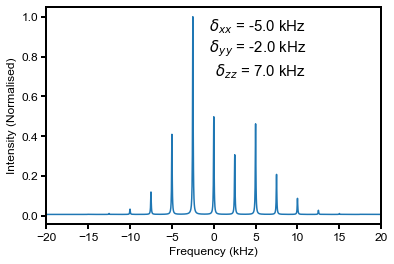

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.set_facecolor("white")
for i in ["top", "bottom", "left", "right"]:
    ax.spines[i].set_linewidth(2)
    ax.spines[i].set_edgecolor("k")

ax.tick_params(axis="both", width=2, length=5, labelsize=12, labelcolor="k", color="k")
ax.plot(xscale/1000, ft.real / np.max(ft.real), color="tab:blue")
ax.set_xlim(-20, 20)
ax.set_xlabel("Frequency (kHz)", color="k", fontsize=12)
ax.set_ylabel("Intensity (Normalised)", color="k", fontsize=12)
ax.text(11, 1, info, fontsize=15, va="top", ha="right")
plt.show()